In [10]:
## data
import pandas as pd
import numpy as np
import datetime as dt
from dateutil.relativedelta import relativedelta
from unicodedata import normalize

## vis
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
# contagem de aging
from collections import Counter

from IPython.display import display, HTML

## modelo
from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# check xgboost version
from xgboost import XGBClassifier

## alertas
import warnings
warnings.filterwarnings("ignore")

***
## Coleta de dados

In [11]:
FILE = "/kaggle/input/datasetsnew/batdtfim500kage.csv"
dados = pd.read_csv(FILE, sep = ';', encoding = 'ISO-8859-1', engine ='python')

dados = dados.rename(columns={'a.msisdn': 'msisdn'})\
             .rename(columns={'a.imsi': 'imsi'})\
             .rename(columns={'a.tac': 'tac'})\
             .rename(columns={'a.dt_inicio': 'dt_inicio'})\
             .rename(columns={'a.dt_fim': 'dt_fim'})\
             .rename(columns={'a.aging_aparelho': 'aging_aparelho'})\
             .rename(columns={'a.cat_aparelho': 'cat_aparelho'})\
             .rename(columns={'a.trocou_aparelho': 'trocou_aparelho'})\
             .rename(columns={'a.fabricante': 'fabricante'})\
             .rename(columns={'a.modelo': 'modelo'})\
             .rename(columns={'a.imei': 'imei'})\
             .rename(columns={'a.ranking': 'ranking'})\
             .rename(columns={'a.cpfidentifier': 'cpfidentifier'})\
             .rename(columns={'a.subscriberkey': 'subscriberkey'})\
             .rename(columns={'a.customerkey': 'customerkey'})\
             .rename(columns={'a.customersubtypedesc': 'customersubtypedesc'})\
             .rename(columns={'a.subscriberstatuskey': 'subscriberstatuskey'})\
             .rename(columns={'a.offertechnology': 'offertechnology'})\
             .rename(columns={'a.citydesc': 'citydesc'})\
             .rename(columns={'a.statedesc': 'statedesc'})\
             .rename(columns={'a.subscribermainofferdesc': 'subscribermainofferdesc'})\
             .rename(columns={'a.assignedchargeamount': 'assignedchargeamount'})\
             .rename(columns={'a.fl_3g': 'fl_3g'})\
             .rename(columns={'a.fl_4g': 'fl_4g'})\
             .rename(columns={'a.fl_5g': 'fl_5g'})\
             .rename(columns={'a.dt_ano_stts': 'dt_ano_stts'})\
             .rename(columns={'a.idade': 'idade'})\

dados = dados[dados['offertechnology'] == 'Controle']

dados

,msisdn,imsi,tac,dt_inicio,dt_fim,aging_aparelho,cat_aparelho,trocou_aparelho,fabricante,modelo,...,offertechnology,citydesc,statedesc,subscribermainofferdesc,assignedchargeamount,fl_3g,fl_4g,fl_5g,dt_ano_stts,idade
1,5521988674638,724112005547717,35690411,2021-05-29,NaN,16,1,0,"Motorola Mobility LLC, a Lenovo Company",ODESSA20,...,Controle,NaN,RIO DE JANEIRO,VIVO CTRL DIGITAL_11GB ILIM_,67.14,0.0,1.0,0.0,2020.0,83
3,5527997623734,724113001405241,35991710,2021-05-29,NaN,16,1,0,Multilaser Industrial S.A.,MULTILASER F PRO,...,Controle,NaN,ESPIRITO SANTO,VIVO CONTROLE DIG-7GB_,52.88,0.0,1.0,0.0,2019.0,65
4,5567996046665,724066795495313,35613011,2021-07-23,NaN,14,1,0,SAMSUNG,"GALAXY A01 (SM-A015M,DS)",...,Controle,NaN,MATO GROSSO DO SUL,VIVO CONTROLE 4GB IV,37.49,0.0,1.0,0.0,2020.0,48
6,5511997089585,724101993173553,35188909,2021-08-04,NaN,14,1,0,MOTOROLA,MOTOROLA MOTO G5S (XT1792),...,Controle,NaN,SAO PAULO,VIVO CONTROLE 7GB_,53.35,0.0,1.0,0.0,2017.0,61
9,5592991404472,724119791658359,35447511,2021-10-11,NaN,12,1,0,Samsung Korea,GALAXY A10S,...,Controle,NaN,AMAZONAS,VIVO CONTROLE 4GB II,34.99,0.0,1.0,0.0,2019.0,45
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499992,5519997894130,724102008047199,35078434,2021-10-07,NaN,12,1,0,Samsung Korea,GALAXY A32 LTE,...,Controle,NaN,SAO PAULO,NaN,NaN,0.0,1.0,0.0,2020.0,63
499993,5564996056038,724066637403568,35634209,2021-06-28,NaN,15,1,0,SAMSUNG,GALAXY J5 PRIME DUOS (SM-G570M DS),...,Controle,NaN,MINAS GERAIS,VIVO CONTROLE 6GB III,45.99,0.0,1.0,0.0,2018.0,45
499996,5511941319852,724102190782505,35092033,2021-03-25,NaN,18,1,0,"Motorola Mobility LLC, a Lenovo Company",GUAM+20,...,Controle,NaN,SAO PAULO,VIVO CONTROLE 7GB_,53.35,0.0,1.0,0.0,2020.0,50
499997,5518996551019,724101993846396,35690411,2021-09-03,NaN,13,1,0,"Motorola Mobility LLC, a Lenovo Company",ODESSA20,...,Controle,NaN,SAO PAULO,VIVO CONTROLE 4GB,37.61,0.0,1.0,0.0,2020.0,58


### Limpeza dos dados

In [12]:
def just_check_nan(df):
    # Check NaN Pandas and Numpy
    missing_val_count_by_column = (df.isna().sum())

    columns_with_nan = missing_val_count_by_column[missing_val_count_by_column > 0]
    print('Dados com NaN:')
    print(columns_with_nan)
    print('')
    print('columns_with_nan.shape', columns_with_nan.shape)
    print('')

In [13]:
just_check_nan(dados)

Dados com NaN:
dt_fim                     286200
citydesc                   358773
statedesc                      10
subscribermainofferdesc     36099
assignedchargeamount        36036
fl_3g                          69
fl_4g                          69
fl_5g                          69
dt_ano_stts                    69
dtype: int64

columns_with_nan.shape (9,)



In [14]:
dados_droped = dados.dropna(subset=['imsi',
                                    'statedesc', 
                                    'subscribermainofferdesc', 
                                    'assignedchargeamount', 'fl_3g', 'fl_4g', 'fl_5g', 'dt_ano_stts'])\
                    .reset_index(drop=True)
# dados_droped

In [15]:
just_check_nan(dados_droped)

Dados com NaN:
dt_fim      253164
citydesc    322562
dtype: int64

columns_with_nan.shape (2,)



### Equilibrando classes

In [16]:
dados_droped_0 = dados_droped[dados_droped['trocou_aparelho'] == 0].sample(frac=0.53, random_state=3)
dados_droped_1 = dados_droped[dados_droped['trocou_aparelho'] == 1]

In [17]:
dados_droped = pd.concat([dados_droped_0, dados_droped_1]).reset_index(drop=True).sort_values(by='msisdn', ascending=False)
dados_droped

,msisdn,imsi,tac,dt_inicio,dt_fim,aging_aparelho,cat_aparelho,trocou_aparelho,fabricante,modelo,...,offertechnology,citydesc,statedesc,subscribermainofferdesc,assignedchargeamount,fl_3g,fl_4g,fl_5g,dt_ano_stts,idade
99933,5599999844114,724119896659201,35194123,2021-04-30,NaN,17,1,0,APPLE,IPHONE 11 (A2221),...,Controle,NaN,MARANHAO,VIVO CONTROLE 11GB - ANUAL,66.20,0.0,1.0,0.0,2020.0,52
33090,5599999019207,724119896575781,86193705,2021-09-20,NaN,13,1,0,XIAOMI,POCO M3 (M2010J19CG),...,Controle,NaN,MARANHAO,VIVO CONTROLE 4GB,36.86,0.0,1.0,0.0,2020.0,39
166948,5599992381199,724119897221361,35305511,2021-05-05,2022-06-20,13,1,1,APPLE,IPHONE 12 (A2403),...,Controle,NaN,MATO GROSSO DO SUL,VIVO CONTROLE 8GB,90.99,0.0,0.0,1.0,2020.0,33
102489,5599992317613,724119898130758,35992599,2021-10-19,NaN,12,1,0,"Motorola Mobility LLC, a Lenovo Company",MALTA20,...,Controle,NaN,MARANHAO,VIVO CTRL DIGITAL-11GB ILIM_,66.20,0.0,1.0,0.0,2020.0,72
141384,5599992316296,724119895474064,35695408,2021-02-26,2022-04-20,13,1,1,SAMSUNG,GALAXY GRAND PRIME DUOS (SM-G532M DS),...,Controle,NaN,MARANHAO,VIVO CONTROLE 4GB IV,32.49,0.0,1.0,0.0,2016.0,56
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141770,5511910006348,724102802378897,35690311,2021-02-12,2022-03-03,12,1,1,"Motorola Mobility LLC, a Lenovo Company",MOTO E(6)S,...,Controle,NaN,SAO PAULO,CONTROLE VANTAGENS 10GB,64.99,0.0,1.0,0.0,2020.0,69
188413,5511910005533,724102902203195,35690708,2020-12-29,2022-05-05,16,1,1,SAMSUNG,GALAXY A5 (SM-A520F DS),...,Controle,NaN,SAO PAULO,VIVO CONTROLE 9GB I,57.01,0.0,1.0,0.0,2016.0,61
136418,5511910004670,724102802008236,35293009,2020-12-18,2022-05-08,16,1,1,SAMSUNG,GALAXY GRAND PRIME DUOS (SM-G532MT),...,Controle,NaN,SAO PAULO,VIVO CONTROLE 4GB,37.61,0.0,1.0,0.0,2017.0,82
103468,5511910003293,724102007432614,35175910,2021-08-02,NaN,14,1,0,SAMSUNG,GALAXY J6 PLUS (SM-J610F),...,Controle,NaN,SAO PAULO,VIVO CONTROLE 11GB I,72.60,0.0,1.0,0.0,2018.0,42


In [18]:
# checando balanço das classes
y_trocou_aparelho = dados_droped['trocou_aparelho']

c_trocou_aparelho = Counter(y_trocou_aparelho)
c_trocou_aparelho

Counter({0: 131556, 1: 74343})

In [19]:
dados_droped = dados_droped.tail(dados_droped.shape[0] -70000).reset_index(drop=True)
dados_droped['dt_ano_stts'] = dados_droped['dt_ano_stts'].astype(np.int64).reset_index(drop=True)
# dados_droped2 = dados_droped[dados_droped['trocou_aparelho'] == 1].reset_index()
dados_droped

,msisdn,imsi,tac,dt_inicio,dt_fim,aging_aparelho,cat_aparelho,trocou_aparelho,fabricante,modelo,...,offertechnology,citydesc,statedesc,subscribermainofferdesc,assignedchargeamount,fl_3g,fl_4g,fl_5g,dt_ano_stts,idade
0,5551981384422,724065191556454,35823453,2021-09-12,NaN,13,1,0,"Motorola Mobility LLC, a Lenovo Company",CAPRIPLUS21,...,Controle,NaN,RIO GRANDE DO SUL,CONTROLE VANTAGENS 10GB,64.99,0.0,1.0,0.0,2020,57
1,5551981375542,724065191731792,35847409,2021-02-26,2022-06-09,15,1,1,SAMSUNG,GALAXY J6 (SM-J600GT DS),...,Controle,NaN,RIO GRANDE DO SUL,VIVO CONTROLE 11GB - ANUAL,72.03,0.0,1.0,0.0,2018,39
2,5551981373908,724065191729020,35551411,2021-05-28,NaN,16,1,0,Samsung Korea,GALAXY A11,...,Controle,NaN,RIO GRANDE DO SUL,VIVO CONTROLE 11GB I,71.99,0.0,1.0,0.0,2020,36
3,5551981369498,724065303306695,35396026,2021-10-02,NaN,12,1,0,Samsung Korea,GALAXY S20 FE LTE,...,Controle,NaN,RIO GRANDE DO SUL,VIVO CONTROLE 6GB III,45.99,0.0,1.0,0.0,2021,44
4,5551981369393,724065007477780,35501510,2020-11-26,2022-02-21,14,1,1,SAMSUNG,"GALAXY S10E (SM-G970F,DS)",...,Controle,NaN,RIO GRANDE DO SUL,VIVO CONTROLE 9GB I,56.49,0.0,1.0,0.0,2018,60
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135894,5511910006348,724102802378897,35690311,2021-02-12,2022-03-03,12,1,1,"Motorola Mobility LLC, a Lenovo Company",MOTO E(6)S,...,Controle,NaN,SAO PAULO,CONTROLE VANTAGENS 10GB,64.99,0.0,1.0,0.0,2020,69
135895,5511910005533,724102902203195,35690708,2020-12-29,2022-05-05,16,1,1,SAMSUNG,GALAXY A5 (SM-A520F DS),...,Controle,NaN,SAO PAULO,VIVO CONTROLE 9GB I,57.01,0.0,1.0,0.0,2016,61
135896,5511910004670,724102802008236,35293009,2020-12-18,2022-05-08,16,1,1,SAMSUNG,GALAXY GRAND PRIME DUOS (SM-G532MT),...,Controle,NaN,SAO PAULO,VIVO CONTROLE 4GB,37.61,0.0,1.0,0.0,2017,82
135897,5511910003293,724102007432614,35175910,2021-08-02,NaN,14,1,0,SAMSUNG,GALAXY J6 PLUS (SM-J610F),...,Controle,NaN,SAO PAULO,VIVO CONTROLE 11GB I,72.60,0.0,1.0,0.0,2018,42


In [20]:
dados_droped.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135899 entries, 0 to 135898
Data columns (total 27 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   msisdn                   135899 non-null  int64  
 1   imsi                     135899 non-null  int64  
 2   tac                      135899 non-null  int64  
 3   dt_inicio                135899 non-null  object 
 4   dt_fim                   44710 non-null   object 
 5   aging_aparelho           135899 non-null  int64  
 6   cat_aparelho             135899 non-null  int64  
 7   trocou_aparelho          135899 non-null  int64  
 8   fabricante               135899 non-null  object 
 9   modelo                   135899 non-null  object 
 10  imei                     135899 non-null  object 
 11  ranking                  135899 non-null  int64  
 12  cpfidentifier            135899 non-null  int64  
 13  subscriberkey            135899 non-null  int64  
 14  cust

***
### Analise individual

In [21]:
dados_droped['cat_aparelho'].unique()

array([1])

In [22]:
dados_droped['trocou_aparelho'].unique()

array([0, 1])

In [23]:
dados_droped['aging_aparelho'].unique()

array([13, 15, 16, 12, 14, 17, 18])

In [24]:
dados_droped['customersubtypedesc'].unique()

array(['Pessoa FÃ\xadsica'], dtype=object)

In [25]:
dados_droped['subscriberstatuskey'].unique()

array(['A'], dtype=object)

In [26]:
dados_droped['ranking'].unique()

array([1, 2])

In [27]:
dados_droped['assignedchargeamount'].unique()

array([ 64.99,  72.03,  71.99,  45.99,  56.49,  57.88,  67.03,  50.99,
        52.88,  61.99,  44.99,  76.99,  61.49,  54.99,  86.99,  56.99,
        59.99,  41.82,  89.97,  37.31,  95.99,  36.99,  86.26,  73.99,
        37.49,  68.99,  22.99,  32.49,  26.99,  41.99,  55.99,  32.59,
        66.99,  27.49,  46.99,  39.99,  85.36,  42.31,  69.99,  60.99,
        81.26,  64.32,  50.59,  90.99,  46.82,  27.99,  40.65,  17.99,
        51.99,  34.99,  77.89,  65.99,  31.99,  52.49,  29.99,  44.02,
       115.99,  67.39,  71.43,  57.4 ,  85.99,  43.84,  66.89, 106.89,
        55.59, 107.98,  46.97,  78.6 ,  49.99,  80.36,  91.99,  32.31,
        69.89,  48.84,  20.3 ,  45.65,  24.8 ,  66.43,  48.99,  60.53,
        75.89,  76.38,  67.88,  65.53,  36.6 ,  43.99,  51.4 ,  42.1 ,
       108.04,  81.99,  54.68,  80.59,  36.82,  78.99,  51.97,  79.02,
       120.99,  54.32,  49.3 ,  48.4 ,  94.97,  80.89,  82.21,  50.65,
        34.63,  37.59,  27.8 ,  85.59,  80.99,  32.99,  52.31,  83.6 ,
      

In [28]:
dados_droped['fl_3g'].equals(dados_droped['fl_4g'])

False

In [29]:
dados_droped['fl_3g'].equals(dados_droped['fl_5g'])

False

In [30]:
dados_droped['fl_4g'].equals(dados_droped['fl_5g'])

False

In [31]:
dados_droped['trocou_aparelho'].unique()

array([0, 1])

In [32]:
dados_droped['idade'].unique()

array([ 57,  39,  36,  44,  60,  76,  56,  38,  67,  32,  54,  31,  58,
        42,  47,  35,  50,  63,  69,  75,  62,  45,  55,  53,  64,  40,
        48,  68,  24,  65,  41,  30,  33,  43,  23,  52,  21,  27,  22,
        59,  28,  61,  46,  37,  20,  26,  49,  34,  66,  29,  19,  74,
        25,  79,  51,  80,  70,  71,  81,  77,  83,  78,  93,  84,  72,
        18,  73,  91,  82,  88,   1,  85, 122, 102,  86,  87,  92,  94,
        89,   2,   4,  90,  96,  11,  17, 111,  16,  95])

***
## Exploração dos dados

### seleção de features

In [33]:
# define features
X_ta = dados_droped[['fabricante', 'modelo', 'ranking', 'aging_aparelho', 
                     'offertechnology', 
                     'statedesc', 'subscribermainofferdesc', 'assignedchargeamount', 
                     'fl_3g', 'fl_4g', 'fl_5g', 'dt_ano_stts', 'idade']]
X_ta

,fabricante,modelo,ranking,aging_aparelho,offertechnology,statedesc,subscribermainofferdesc,assignedchargeamount,fl_3g,fl_4g,fl_5g,dt_ano_stts,idade
0,"Motorola Mobility LLC, a Lenovo Company",CAPRIPLUS21,1,13,Controle,RIO GRANDE DO SUL,CONTROLE VANTAGENS 10GB,64.99,0.0,1.0,0.0,2020,57
1,SAMSUNG,GALAXY J6 (SM-J600GT DS),1,15,Controle,RIO GRANDE DO SUL,VIVO CONTROLE 11GB - ANUAL,72.03,0.0,1.0,0.0,2018,39
2,Samsung Korea,GALAXY A11,1,16,Controle,RIO GRANDE DO SUL,VIVO CONTROLE 11GB I,71.99,0.0,1.0,0.0,2020,36
3,Samsung Korea,GALAXY S20 FE LTE,1,12,Controle,RIO GRANDE DO SUL,VIVO CONTROLE 6GB III,45.99,0.0,1.0,0.0,2021,44
4,SAMSUNG,"GALAXY S10E (SM-G970F,DS)",1,14,Controle,RIO GRANDE DO SUL,VIVO CONTROLE 9GB I,56.49,0.0,1.0,0.0,2018,60
...,...,...,...,...,...,...,...,...,...,...,...,...,...
135894,"Motorola Mobility LLC, a Lenovo Company",MOTO E(6)S,1,12,Controle,SAO PAULO,CONTROLE VANTAGENS 10GB,64.99,0.0,1.0,0.0,2020,69
135895,SAMSUNG,GALAXY A5 (SM-A520F DS),1,16,Controle,SAO PAULO,VIVO CONTROLE 9GB I,57.01,0.0,1.0,0.0,2016,61
135896,SAMSUNG,GALAXY GRAND PRIME DUOS (SM-G532MT),1,16,Controle,SAO PAULO,VIVO CONTROLE 4GB,37.61,0.0,1.0,0.0,2017,82
135897,SAMSUNG,GALAXY J6 PLUS (SM-J610F),1,14,Controle,SAO PAULO,VIVO CONTROLE 11GB I,72.60,0.0,1.0,0.0,2018,42


In [34]:
X_ta.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135899 entries, 0 to 135898
Data columns (total 13 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   fabricante               135899 non-null  object 
 1   modelo                   135899 non-null  object 
 2   ranking                  135899 non-null  int64  
 3   aging_aparelho           135899 non-null  int64  
 4   offertechnology          135899 non-null  object 
 5   statedesc                135899 non-null  object 
 6   subscribermainofferdesc  135899 non-null  object 
 7   assignedchargeamount     135899 non-null  float64
 8   fl_3g                    135899 non-null  float64
 9   fl_4g                    135899 non-null  float64
 10  fl_5g                    135899 non-null  float64
 11  dt_ano_stts              135899 non-null  int64  
 12  idade                    135899 non-null  int64  
dtypes: float64(4), int64(4), object(5)
memory usage: 13.5+ MB


#### Variaveis Categoricas

In [35]:
# Get list of categorical variables
s_ta = (X_ta.dtypes == 'object')
object_cols_ta = list(s_ta[s_ta].index)
print("Categorical variables: ", len(object_cols_ta))
print(object_cols_ta)

Categorical variables:  5
['fabricante', 'modelo', 'offertechnology', 'statedesc', 'subscribermainofferdesc']


#### Variaveis Numéricas

In [36]:
# Criando uma lista de variaveis numéricas
numerical_cols_ta = [cname for cname in X_ta.columns if X_ta[cname].dtype in ['int64', 'float64']]
print("Numerical variables: ", len(numerical_cols_ta))
print(numerical_cols_ta)

Numerical variables:  8
['ranking', 'aging_aparelho', 'assignedchargeamount', 'fl_3g', 'fl_4g', 'fl_5g', 'dt_ano_stts', 'idade']


***
## Mostrando a correlação entre os dados numéricos

In [37]:
corr_trocou_aparelho = dados_droped[['fabricante', 'modelo',
                                     'ranking', 'aging_aparelho',
                                     'offertechnology', 
                                     'statedesc', 'subscribermainofferdesc',
                                     'assignedchargeamount', 'fl_3g', 'fl_4g', 'fl_5g',
                                     'dt_ano_stts', 'idade', 'trocou_aparelho']]

<AxesSubplot:>

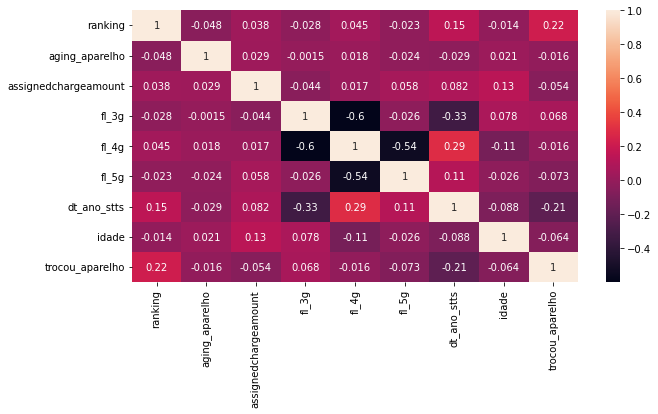

In [38]:
corr = corr_trocou_aparelho.corr()

fig, ax = plt.subplots(figsize=(10,5))
sns.heatmap(corr, xticklabels = corr.columns, yticklabels = corr.columns, annot = True)

In [39]:
dados_droped['mes_jan'] = (pd.to_datetime(dados_droped['dt_inicio']).dt.to_period('M') == '2020-01') | \
                          (pd.to_datetime(dados_droped['dt_inicio']).dt.to_period('M') == '2021-01')

dados_droped['mes_fev'] = (pd.to_datetime(dados_droped['dt_inicio']).dt.to_period('M') == '2020-02') | \
                          (pd.to_datetime(dados_droped['dt_inicio']).dt.to_period('M') == '2021-02')

dados_droped['mes_mar'] = (pd.to_datetime(dados_droped['dt_inicio']).dt.to_period('M') == '2020-03') | \
                          (pd.to_datetime(dados_droped['dt_inicio']).dt.to_period('M') == '2021-03')

dados_droped['mes_abr'] = (pd.to_datetime(dados_droped['dt_inicio']).dt.to_period('M') == '2020-04') | \
                          (pd.to_datetime(dados_droped['dt_inicio']).dt.to_period('M') == '2021-04')

dados_droped['mes_mai'] = (pd.to_datetime(dados_droped['dt_inicio']).dt.to_period('M') == '2020-05') | \
                          (pd.to_datetime(dados_droped['dt_inicio']).dt.to_period('M') == '2021-05')

dados_droped['mes_jun'] = (pd.to_datetime(dados_droped['dt_inicio']).dt.to_period('M') == '2020-06') | \
                          (pd.to_datetime(dados_droped['dt_inicio']).dt.to_period('M') == '2021-06')

dados_droped['mes_jul'] = (pd.to_datetime(dados_droped['dt_inicio']).dt.to_period('M') == '2020-07') | \
                          (pd.to_datetime(dados_droped['dt_inicio']).dt.to_period('M') == '2021-07')  
                                                
dados_droped['mes_ago'] = (pd.to_datetime(dados_droped['dt_inicio']).dt.to_period('M') == '2020-08') | \
                          (pd.to_datetime(dados_droped['dt_inicio']).dt.to_period('M') == '2021-08')

dados_droped['mes_set'] = (pd.to_datetime(dados_droped['dt_inicio']).dt.to_period('M') == '2020-09') | \
                          (pd.to_datetime(dados_droped['dt_inicio']).dt.to_period('M') == '2021-09')

dados_droped['mes_out'] = (pd.to_datetime(dados_droped['dt_inicio']).dt.to_period('M') == '2020-10') | \
                          (pd.to_datetime(dados_droped['dt_inicio']).dt.to_period('M') == '2021-10')

dados_droped['mes_nov'] = (pd.to_datetime(dados_droped['dt_inicio']).dt.to_period('M') == '2020-11') | \
                          (pd.to_datetime(dados_droped['dt_inicio']).dt.to_period('M') == '2021-11')

dados_droped['mes_dez'] = (pd.to_datetime(dados_droped['dt_inicio']).dt.to_period('M') == '2020-12') | \
                          (pd.to_datetime(dados_droped['dt_inicio']).dt.to_period('M') == '2021-12')

In [40]:
corr_meses_troca = dados_droped[['mes_jan', 'mes_fev', 'mes_mar', 'mes_abr', 
								 'mes_mai', 'mes_jun', 'mes_jul', 'mes_ago', 
								 'mes_set', 'mes_out', 'mes_nov', 'mes_dez', 'trocou_aparelho']]

<AxesSubplot:>

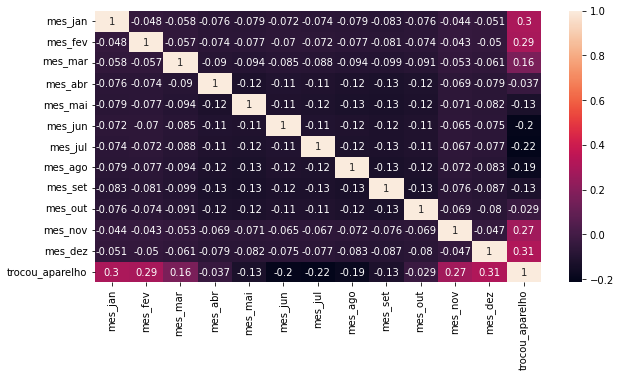

In [41]:
corr_Test = corr_meses_troca.corr()

fig, ax = plt.subplots(figsize=(10,5))
sns.heatmap(corr_Test, xticklabels = corr_Test.columns, yticklabels = corr_Test.columns, annot = True)

***
***
***
## Definição do Target trocou_aparelho

In [42]:
def plot_feature_freq(df, feature, qt_cat):
    labels, counts = np.unique(df[feature].dropna(), return_counts=True)

    # ordena pelas mais frequentes
    order = np.argsort(counts)[::-1]
    labels, counts = labels[order], counts[order]

    g = sns.barplot(labels[:qt_cat], counts[:qt_cat])
    g.set_xticklabels(labels[:qt_cat], rotation=90)
    
    return g

In [43]:
# define target
y_trocou_aparelho = dados_droped['trocou_aparelho']

c_trocou_aparelho = Counter(y_trocou_aparelho)
c_trocou_aparelho

Counter({0: 87786, 1: 48113})

In [44]:
# # calculo da proporção da base
# estimate = c_trocou_aparelho[0] / c_trocou_aparelho[1]
# estimate

<AxesSubplot:>

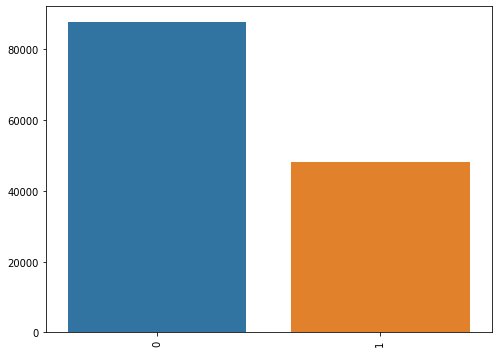

In [45]:
plt.figure(figsize=(8, 6))

# plot_feature_freq(df, feature, qt_cat)
plot_feature_freq(dados_droped, 'trocou_aparelho', len(dados_droped['trocou_aparelho'].unique()))

***
## Modelagem trocou_aparelho

In [46]:
# Dividindo as features em dados de treino e teste
X_train_ta, X_val_ta, y_train_ta, y_val_ta = train_test_split(X_ta, 
                                                              y_trocou_aparelho, 
                                                              test_size=0.5, 
                                                              random_state = 2048)

# Pré-processamento para Dados Numéricos
numerical_transformer_ta = Pipeline([
                                     ('scaler', StandardScaler())
                                    ])

# Pré-processamento para Dados Categóricos
categorical_transformer_ta = Pipeline([
                                       ('onehot', OneHotEncoder(handle_unknown='ignore', sparse=False))
                                      ])

# Pré-processamento de pacote de dados numéricos e categóricos
preprocessor_ta = ColumnTransformer(transformers=[
                                                  ('num', numerical_transformer_ta, numerical_cols_ta),
                                                  ('cat', categorical_transformer_ta, object_cols_ta)
                                                 ], n_jobs=-1)

pipeline_ta = Pipeline(steps=[
                              ('preprocessor', preprocessor_ta),
                              ('smote', SMOTE(random_state=42, n_jobs=-1)),
#                               ('model', RandomForestClassifier(random_state=2048))
                              ('model', GradientBoostingClassifier(random_state=2048))
#                               ('model', XGBClassifier(scale_pos_weight=estimate, random_state=2048))
                             ])

# Preprocessing of training data, fit model 
pipeline_ta.fit(X_train_ta, y_train_ta)

# Predictions
# preds = np.asarray(pipeline.predict(X_val), dtype = 'int')
preds_ta = pipeline_ta.predict(X_val_ta)

In [47]:
c_train_ta = Counter(y_train_ta)
c_train_ta


Counter({1: 24114, 0: 43835})

In [48]:
c_val_ta = Counter(y_val_ta)
c_val_ta


Counter({0: 43951, 1: 23999})

In [49]:
c_preds_ta = Counter(preds_ta)
c_preds_ta

Counter({1: 32269, 0: 35681})

***
## Métricas

In [50]:
print(classification_report(y_val_ta, preds_ta))

              precision    recall  f1-score   support

           0       0.79      0.64      0.71     43951
           1       0.52      0.69      0.59     23999

    accuracy                           0.66     67950
   macro avg       0.65      0.67      0.65     67950
weighted avg       0.70      0.66      0.67     67950



In [51]:
cm_df_ta = pd.DataFrame(confusion_matrix(y_val_ta, preds_ta),
                     index = sorted(Counter(y_val_ta)),
                     columns = sorted(Counter(preds_ta)))
cm_df_ta

,0,1
0,28323,15628
1,7358,16641


Confusion matrix, without normalization
[[28323 15628]
 [ 7358 16641]]
Normalized confusion matrix
[[0.6444222  0.3555778 ]
 [0.30659611 0.69340389]]


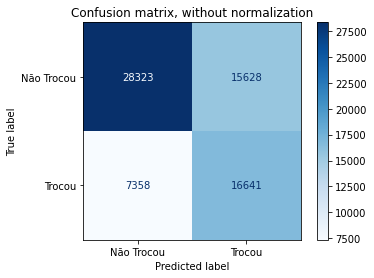

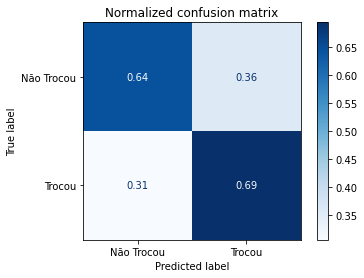

<Figure size 1296x1296 with 0 Axes>

In [52]:
# Plot non-normalized confusion matrix
titles_options = [
    ("Confusion matrix, without normalization", None),
    ("Normalized confusion matrix", "true"),
]
for title, normalize in titles_options:
    disp = ConfusionMatrixDisplay.from_estimator(
        pipeline_ta,
        X_val_ta,
        y_val_ta,
        display_labels=['Não Trocou', 'Trocou'],
        cmap=plt.cm.Blues,
        normalize=normalize,
    )
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)
    
plt.figure(figsize=(18, 18))
plt.show()

## Captação dos clientes que foram previstos como Propensos a Fazer uma Compra

In [53]:
X_val_ta['trocou_aparelho'] = y_val_ta
# X_val_ta

<AxesSubplot:>

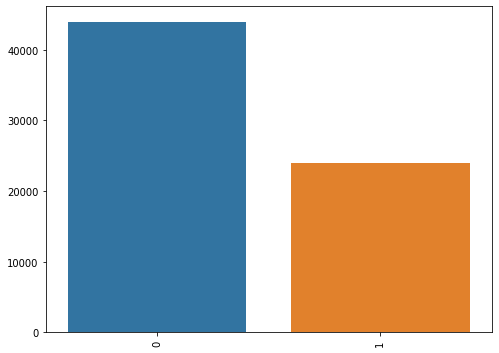

In [54]:
plt.figure(figsize=(8, 6))

# plot_feature_freq(df, feature, qt_cat)
plot_feature_freq(X_val_ta, 'trocou_aparelho', len(X_val_ta['trocou_aparelho'].unique()))

In [55]:
X_val_ta['trocou_aparelho_previsto'] = preds_ta
# X_val_ta

<AxesSubplot:>

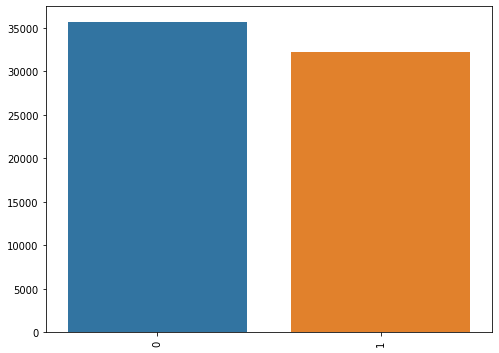

In [56]:
plt.figure(figsize=(8, 6))

# plot_feature_freq(df, feature, qt_cat)
plot_feature_freq(X_val_ta, 'trocou_aparelho_previsto', len(X_val_ta['trocou_aparelho_previsto'].unique()))

In [57]:
X_val_ta['cpfidentifier'] = dados_droped['cpfidentifier']
# X_val_ta

In [58]:
X_val_ta['dt_inicio'] = dados_droped['dt_inicio']
# X_val_ta

In [59]:
X_val_ta['dt_fim'] = dados_droped['dt_fim']
X_val_ta

,fabricante,modelo,ranking,aging_aparelho,offertechnology,statedesc,subscribermainofferdesc,assignedchargeamount,fl_3g,fl_4g,fl_5g,dt_ano_stts,idade,trocou_aparelho,trocou_aparelho_previsto,cpfidentifier,dt_inicio,dt_fim
48027,LG,P698,1,15,Controle,ESPIRITO SANTO,VIVO CONTROLE 11GB - MENSAL,66.43,1.0,0.0,0.0,2011,71,0,1,6083144710,2021-07-13,NaN
132424,MOTOROLA,MOTO G7 POWER (XT1955-1),1,15,Controle,SAO PAULO,VIVO CONTROLE 9GB I,57.01,0.0,1.0,0.0,2018,45,0,1,26804630807,2021-07-02,NaN
15334,Samsung Korea,GALAXY A11,1,15,Controle,MINAS GERAIS,VIVO CTRL DIGITAL-11GB ILIM_,66.34,0.0,1.0,0.0,2020,34,1,0,9524687607,2020-10-16,2022-02-14
96535,LG,LM-K420BMW,1,16,Controle,SAO PAULO,VIVO CONTROLE 9GB I,57.01,0.0,1.0,0.0,2021,51,0,0,12256123812,2021-06-01,NaN
52090,Samsung Korea,GALAXY A02S,1,15,Controle,ESPIRITO SANTO,VIVO CONTROLE 4GB IV,32.49,0.0,1.0,0.0,2020,67,0,0,1533766789,2021-06-29,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37323,"Motorola Mobility LLC, a Lenovo Company",MALTA,1,13,Controle,MINAS GERAIS,VIVO CONTROLE 14GB - ANUAL,91.99,0.0,1.0,0.0,2020,58,0,0,50685686604,2021-09-05,NaN
89972,SAMSUNG,"GALAXY J2 CORE (SM-J260M,DS)",1,14,Controle,SAO PAULO,VIVO CONTROLE 8GB II,55.99,0.0,1.0,0.0,2018,64,0,0,62831780810,2021-08-05,NaN
7688,"Motorola Mobility LLC, a Lenovo Company",MOTO E PLAY (5TH GEN),1,15,Controle,PARANA,VIVO CONTROLE 5GB IV,36.99,0.0,1.0,0.0,2018,43,1,1,2111091936,2021-02-03,2022-05-17
69531,NOKIA,3200,1,12,Controle,RIO DE JANEIRO,VIVO CONTROLE 7GB - MENSAL,51.52,0.0,1.0,0.0,2018,68,0,0,82319251715,2021-10-16,NaN


***
***
***
## Separando as bases para outro modelo

In [60]:
base_to_pred_month = X_val_ta[X_val_ta['trocou_aparelho_previsto'] == 1].reset_index(drop=True)
base_to_pred_month

,fabricante,modelo,ranking,aging_aparelho,offertechnology,statedesc,subscribermainofferdesc,assignedchargeamount,fl_3g,fl_4g,fl_5g,dt_ano_stts,idade,trocou_aparelho,trocou_aparelho_previsto,cpfidentifier,dt_inicio,dt_fim
0,LG,P698,1,15,Controle,ESPIRITO SANTO,VIVO CONTROLE 11GB - MENSAL,66.43,1.0,0.0,0.0,2011,71,0,1,6083144710,2021-07-13,NaN
1,MOTOROLA,MOTO G7 POWER (XT1955-1),1,15,Controle,SAO PAULO,VIVO CONTROLE 9GB I,57.01,0.0,1.0,0.0,2018,45,0,1,26804630807,2021-07-02,NaN
2,Samsung Korea,GALAXY A21S,1,12,Controle,MINAS GERAIS,VIVO CONTROLE 5GB IV,36.99,0.0,1.0,0.0,2020,50,0,1,2730451641,2021-09-25,NaN
3,SAMSUNG,"GALAXY J2 CORE (SM-J260M,DS)",1,18,Controle,RIO GRANDE DO SUL,VIVO CONTROLE 7GB_ANUAL_,51.52,0.0,1.0,0.0,2018,33,1,1,38660885821,2020-08-04,2022-02-11
4,SAMSUNG,"GALAXY A30S (SM-A307G,DS)",1,14,Controle,RIO DE JANEIRO,VIVO CONTROLE 6GB III,50.99,0.0,1.0,0.0,2019,41,0,1,5294300702,2021-08-03,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32264,Samsung Korea,GALAXY A10,1,13,Controle,SAO PAULO,VIVO CONTROLE 4GB IV,32.49,0.0,1.0,0.0,2019,29,0,1,41968173862,2021-08-30,NaN
32265,XIAOMI,REDMI 7 (M1810F6LG),1,12,Controle,MINAS GERAIS,VIVO CONTROLE 11GB I,71.99,0.0,1.0,0.0,2019,45,0,1,8407318680,2021-10-07,NaN
32266,SAMSUNG,GALAXY J5 DUOS (SM-J500M DS),1,14,Controle,SAO PAULO,VIVO CONTROLE 11GB - MENSAL,76.99,0.0,1.0,0.0,2016,70,1,1,85579718853,2021-03-05,2022-05-14
32267,SAMSUNG,GALAXY J1 MINI (SM-J105B DL),1,15,Controle,MINAS GERAIS,VIVO CONTROLE 10GB PLN I - ANUAL,59.63,1.0,0.0,0.0,2016,55,1,1,60991089634,2021-02-19,2022-05-21


***
***
***
## Definição do Target aging_aparelho

In [61]:
# define target
y = base_to_pred_month['aging_aparelho']

In [62]:
# contagem de aging
from collections import Counter

c = Counter(y)
c

Counter({15: 4531, 12: 5924, 18: 3835, 14: 4612, 17: 4028, 16: 3976, 13: 5363})

<AxesSubplot:>

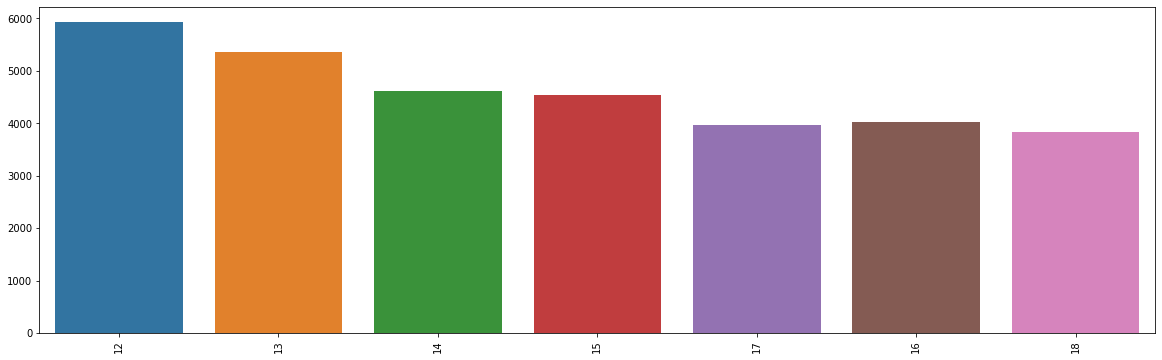

In [63]:
plt.figure(figsize=(20, 6))

# plot_feature_freq(df, feature, qt_cat)
plot_feature_freq(base_to_pred_month, 'aging_aparelho', len(base_to_pred_month['aging_aparelho'].unique()))

### Definicão das features

In [64]:
# define features
X = base_to_pred_month[['fabricante', 'modelo',
                        'ranking',
                        'offertechnology', 
                        'statedesc', 'subscribermainofferdesc',
                        'assignedchargeamount', 'fl_3g', 'fl_4g', 'fl_5g',
                        'dt_ano_stts', 'idade']]
X

,fabricante,modelo,ranking,offertechnology,statedesc,subscribermainofferdesc,assignedchargeamount,fl_3g,fl_4g,fl_5g,dt_ano_stts,idade
0,LG,P698,1,Controle,ESPIRITO SANTO,VIVO CONTROLE 11GB - MENSAL,66.43,1.0,0.0,0.0,2011,71
1,MOTOROLA,MOTO G7 POWER (XT1955-1),1,Controle,SAO PAULO,VIVO CONTROLE 9GB I,57.01,0.0,1.0,0.0,2018,45
2,Samsung Korea,GALAXY A21S,1,Controle,MINAS GERAIS,VIVO CONTROLE 5GB IV,36.99,0.0,1.0,0.0,2020,50
3,SAMSUNG,"GALAXY J2 CORE (SM-J260M,DS)",1,Controle,RIO GRANDE DO SUL,VIVO CONTROLE 7GB_ANUAL_,51.52,0.0,1.0,0.0,2018,33
4,SAMSUNG,"GALAXY A30S (SM-A307G,DS)",1,Controle,RIO DE JANEIRO,VIVO CONTROLE 6GB III,50.99,0.0,1.0,0.0,2019,41
...,...,...,...,...,...,...,...,...,...,...,...,...
32264,Samsung Korea,GALAXY A10,1,Controle,SAO PAULO,VIVO CONTROLE 4GB IV,32.49,0.0,1.0,0.0,2019,29
32265,XIAOMI,REDMI 7 (M1810F6LG),1,Controle,MINAS GERAIS,VIVO CONTROLE 11GB I,71.99,0.0,1.0,0.0,2019,45
32266,SAMSUNG,GALAXY J5 DUOS (SM-J500M DS),1,Controle,SAO PAULO,VIVO CONTROLE 11GB - MENSAL,76.99,0.0,1.0,0.0,2016,70
32267,SAMSUNG,GALAXY J1 MINI (SM-J105B DL),1,Controle,MINAS GERAIS,VIVO CONTROLE 10GB PLN I - ANUAL,59.63,1.0,0.0,0.0,2016,55


#### Variaveis Categoricas

In [65]:
# Get list of categorical variables
s = (X.dtypes == 'object')
object_cols = list(s[s].index)
print("Categorical variables: ", len(object_cols))
print(object_cols)

Categorical variables:  5
['fabricante', 'modelo', 'offertechnology', 'statedesc', 'subscribermainofferdesc']


#### Variaveis Numéricas

In [66]:
# Criando uma lista de variaveis numéricas
numerical_cols = [cname for cname in X.columns if X[cname].dtype in ['int64', 'float64']]
print("Numerical variables: ", len(numerical_cols))
print(numerical_cols)

Numerical variables:  7
['ranking', 'assignedchargeamount', 'fl_3g', 'fl_4g', 'fl_5g', 'dt_ano_stts', 'idade']


***
## Mostrando a correlação entre os dados numéricos

In [67]:
corr_mes_previsao = base_to_pred_month[['fabricante', 'modelo',
                                        'ranking',
                                        'offertechnology', 
                                        'statedesc', 'subscribermainofferdesc',
                                        'assignedchargeamount', 'fl_3g', 'fl_4g', 'fl_5g',
                                        'dt_ano_stts', 'idade', 'aging_aparelho']]

<AxesSubplot:>

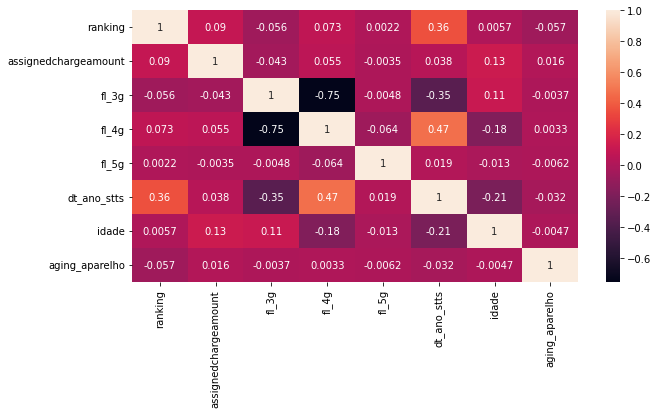

In [68]:
corr2 = corr_mes_previsao.corr()

fig, ax = plt.subplots(figsize=(10,5))
sns.heatmap(corr2, xticklabels = corr2.columns, yticklabels = corr2.columns, annot = True)

***
## Modelagem

In [69]:
# Dividindo as features em dados de treino e teste - 70% para dados de treinamento e 30% para dados de teste
X_train, X_val, y_train, y_val = train_test_split(X, 
                                                  y, 
                                                  test_size=0.5, 
                                                  random_state = 2048)

# Pré-processamento para Dados Numéricos
numerical_transformer = Pipeline([
                                  ('scaler', StandardScaler())
                                 ])

# Pré-processamento para Dados Categóricos
categorical_transformer = Pipeline([
                                    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse=False))
                                   ])

# Pré-processamento de pacote de dados numéricos e categóricos
preprocessor = ColumnTransformer(transformers=[
                                                ('num', numerical_transformer, numerical_cols),
                                                ('cat', categorical_transformer, object_cols)
                                              ], n_jobs=-1)

pipeline = Pipeline(steps=[
                            ('preprocessor', preprocessor),
#                             ('smote', SMOTE(random_state=42, n_jobs=-1)),
                            ('model', RandomForestClassifier(random_state=2048))
#                             ('model', GradientBoostingClassifier(random_state=2048))
#                             ('model', XGBClassifier(scale_pos_weight=estimate, random_state=2048))
                          ])

# Preprocessing of training data, fit model 
pipeline.fit(X_train, y_train)

# Predictions
#preds = np.asarray(pipeline.predict(X_val), dtype = 'int')
preds = pipeline.predict(X_val)

In [70]:
c_train = Counter(y_train)
c_train

Counter({17: 2011, 12: 3030, 13: 2635, 14: 2314, 18: 1888, 16: 2005, 15: 2251})

In [71]:
c_val = Counter(y_val)
c_val

Counter({18: 1947, 12: 2894, 13: 2728, 14: 2298, 16: 1971, 15: 2280, 17: 2017})

In [72]:
c_preds = Counter(preds)
c_preds

Counter({13: 2880, 14: 2221, 12: 3917, 16: 1651, 15: 2178, 17: 1683, 18: 1605})

<AxesSubplot:>

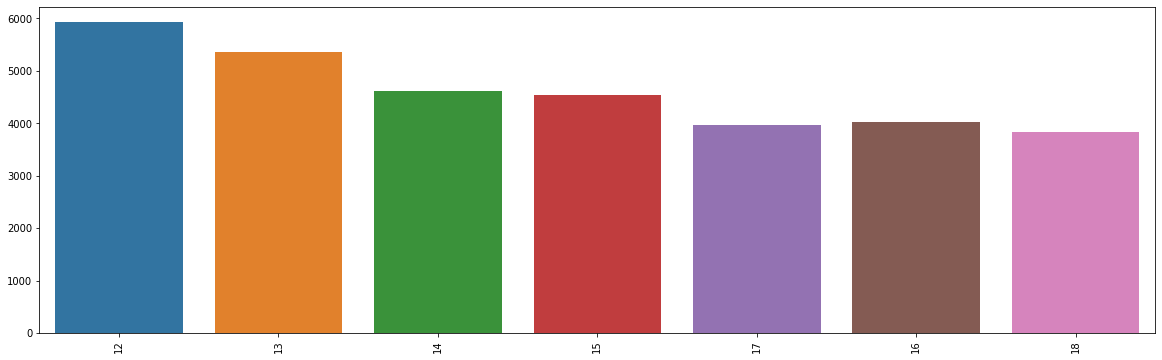

In [73]:
plt.figure(figsize=(20, 6))

# plot_feature_freq(df, feature, qt_cat)
plot_feature_freq(base_to_pred_month, 'aging_aparelho', len(base_to_pred_month['aging_aparelho'].unique()))

***
## Métricas

In [74]:
print(classification_report(y_val, preds))

              precision    recall  f1-score   support

          12       0.21      0.28      0.24      2894
          13       0.19      0.20      0.20      2728
          14       0.18      0.17      0.18      2298
          15       0.18      0.17      0.17      2280
          16       0.13      0.11      0.12      1971
          17       0.18      0.15      0.16      2017
          18       0.18      0.15      0.16      1947

    accuracy                           0.18     16135
   macro avg       0.18      0.18      0.18     16135
weighted avg       0.18      0.18      0.18     16135



In [75]:
cm_df = pd.DataFrame(confusion_matrix(y_val, preds),
                     index = sorted(Counter(y_val)),
                     columns = sorted(Counter(preds)))
cm_df

,12,13,14,15,16,17,18
12,818,570,355,373,296,228,254
13,684,557,362,361,256,246,262
14,521,400,401,308,220,245,203
15,560,371,306,383,238,221,201
16,451,350,251,268,221,228,202
17,442,322,284,252,217,305,195
18,441,310,262,233,203,210,288


## Plot non-normalized confusion matrix

Confusion matrix, without normalization
[[818 570 355 373 296 228 254]
 [684 557 362 361 256 246 262]
 [521 400 401 308 220 245 203]
 [560 371 306 383 238 221 201]
 [451 350 251 268 221 228 202]
 [442 322 284 252 217 305 195]
 [441 310 262 233 203 210 288]]
Normalized confusion matrix
[[0.28265377 0.19695923 0.12266759 0.12888735 0.10228058 0.07878369
  0.0877678 ]
 [0.25073314 0.20417889 0.13269795 0.13233138 0.09384164 0.09017595
  0.09604106]
 [0.22671889 0.1740644  0.17449956 0.13402959 0.09573542 0.10661445
  0.08833768]
 [0.24561404 0.1627193  0.13421053 0.16798246 0.10438596 0.09692982
  0.08815789]
 [0.22881786 0.17757484 0.12734652 0.13597159 0.11212582 0.11567732
  0.10248605]
 [0.21913733 0.15964303 0.14080317 0.12493803 0.10758552 0.15121468
  0.09667824]
 [0.22650231 0.15921931 0.134566   0.11967129 0.10426297 0.10785824
  0.14791988]]


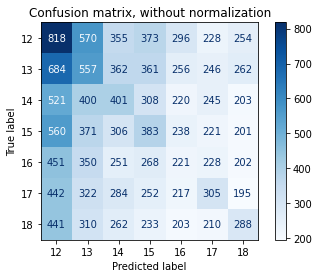

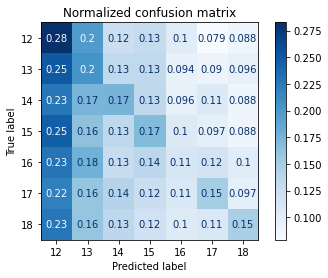

<Figure size 1296x1296 with 0 Axes>

In [76]:
titles_options = [
    ("Confusion matrix, without normalization", None),
    ("Normalized confusion matrix", "true"),
]
for title, normalize in titles_options:
    disp = ConfusionMatrixDisplay.from_estimator(
        pipeline,
        X_val,
        y_val,
        display_labels=['12', '13', '14', '15', '16', '17', '18'],
        cmap=plt.cm.Blues,
        normalize=normalize,
    )
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)
    
plt.figure(figsize=(18, 18))
plt.show()

***
## Mesclando resultados com tabela

### Com a base de validação

In [77]:
X_val['aging_aparelho'] = y_val
# X_val

In [78]:
X_val['previsto'] = preds
# X_val

In [79]:
X_val['cpfidentifier'] = base_to_pred_month['cpfidentifier']
# X_val

In [80]:
X_val['dt_inicio'] = base_to_pred_month['dt_inicio']
# X_val

In [81]:
X_val['dt_fim'] = base_to_pred_month['dt_fim']
# X_val

## Calculando data prevista

In [82]:
X_val['dt_fim_previsto'] = ((pd.to_datetime(X_val['dt_inicio']).dt.to_period('M')) + X_val['previsto'])
X_val

,fabricante,modelo,ranking,offertechnology,statedesc,subscribermainofferdesc,assignedchargeamount,fl_3g,fl_4g,fl_5g,dt_ano_stts,idade,aging_aparelho,previsto,cpfidentifier,dt_inicio,dt_fim,dt_fim_previsto
5834,APPLE,IPHONE 6S PLUS TD-LTE (A1687),1,Controle,MINAS GERAIS,VIVO CONTROLE 7GB_ANUAL_,52.31,0.0,1.0,0.0,2015,68,18,13,18603955620,2021-03-28,NaN,2022-04
18621,APPLE,IPHONE 6 LTE-A (A1549),1,Controle,SAO PAULO,VIVO CONTROLE 7GB_,58.35,0.0,1.0,0.0,2015,28,12,14,44279490880,2021-04-05,2022-04-17,2022-06
8431,SAMSUNG,GALAXY J6 (SM-J600GT DS),1,Controle,SAO PAULO,VIVO CONTROLE 5GB IV,36.99,0.0,1.0,0.0,2018,63,12,12,1544868847,2021-09-29,NaN,2022-09
18913,SAMSUNG,GALAXY J7 PRIME (SM-G610M DS),1,Controle,MINAS GERAIS,VIVO CONTROLE 7GB - MENSAL,56.99,0.0,1.0,0.0,2017,57,18,16,58678115653,2021-04-05,NaN,2022-08
23332,XIAOMI,MI 9 (M1902F1G),1,Controle,PARANA,VIVO CONTROLE 7GB_,56.27,0.0,1.0,0.0,2019,49,18,16,48928097134,2021-04-09,NaN,2022-08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17909,SAMSUNG,GALAXY J5 PRIME DUOS (SM-G570M DS),1,Controle,SAO PAULO,VIVO CONTROLE 7GB_ANUAL_,53.35,0.0,1.0,0.0,2017,43,12,13,28252424899,2021-10-20,NaN,2022-11
2155,SAMSUNG,GALAXY A20S (SM-A207M),1,Controle,MINAS GERAIS,VIVO CONTROLE 4GB IV,32.49,0.0,1.0,0.0,2019,82,15,13,71225480400,2021-07-02,NaN,2022-08
8043,Samsung Korea,GALAXY A10,1,Controle,SAO PAULO,VIVO CONTROLE-9GB ILIM_,61.27,0.0,1.0,0.0,2019,41,18,12,22522666860,2021-04-13,NaN,2022-04
13483,MOTOROLA,MOTO G7 POWER (XT1955-1),1,Controle,SAO PAULO,VIVO CONTROLE DIG-7GB_,53.35,0.0,1.0,0.0,2018,28,14,12,34654620842,2021-01-07,2022-03-27,2022-01


In [83]:
c_preds

Counter({13: 2880, 14: 2221, 12: 3917, 16: 1651, 15: 2178, 17: 1683, 18: 1605})

<AxesSubplot:>

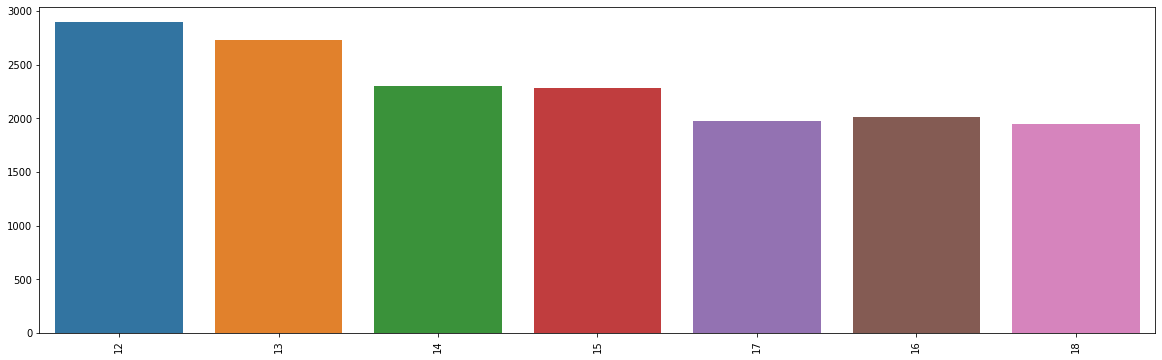

In [84]:
plt.figure(figsize=(20, 6))

# plot_feature_freq(df, feature, qt_cat)
plot_feature_freq(X_val, 'aging_aparelho', len(X_val['aging_aparelho'].unique()))

<AxesSubplot:>

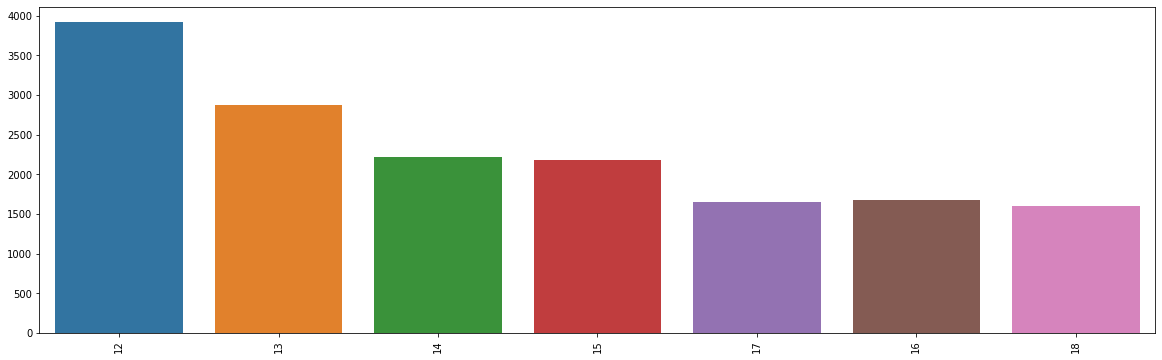

In [85]:
plt.figure(figsize=(20, 6))

# plot_feature_freq(df, feature, qt_cat)
plot_feature_freq(X_val, 'previsto', len(X_val['previsto'].unique()))